# 📚 Fake News Detection mit Machine Learning

## 🧭 Projektüberblick

In diesem Projekt geht es um die automatische Erkennung von Fake News anhand von Textdaten. Ziel ist es, mithilfe von Natural Language Processing (NLP) und Machine Learning (ML) ein Modell zu entwickeln, das gefälschte Nachrichtenartikel von echten unterscheiden kann.

Die verwendeten Daten stammen von der Plattform [Kaggle](https://www.kaggle.com/code/therealsampat/fake-news-detection/input?select=Fake.csv) und beinhalten echte sowie gefälschte Nachrichtenartikel. Das Projekt umfasst folgende Schritte:

- Datenimport und Zusammenführung
- Explorative Datenanalyse (EDA)
- Textvorverarbeitung und Merkmalsextraktion
- Modelltraining mit Random Forest
- Evaluierung und Interpretation der Ergebnisse

Die Pipeline soll möglichst verständlich, reproduzierbar und nachvollziehbar gestaltet sein.


## 📦 Pakete installieren & importieren

Zunächst installieren und importieren wir alle notwendigen Bibliotheken für Datenanalyse, Visualisierung und maschinelles Lernen. Zusätzlich verwenden wir `gdown`, um die CSV-Dateien direkt von Google Drive herunterzuladen.

In [2]:
# Optional: gdown installieren, falls lokal oder erstmalig ausgeführt
!pip install -q gdown

# 🔁 Pakete für Datenverarbeitung und Visualisierung
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 🤖 Pakete für Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 📥 Tool für Google Drive Download
import gdown

## 📥 Daten herunterladen & laden

Die beiden Datensätze beinhalten echte und gefälschte Nachrichtenartikel. Wir laden sie über ihre Google-Drive-Datei-IDs herunter, lesen sie ein und versehen sie mit entsprechenden Labeln (`0` für real, `1` für fake).

In [3]:
# IDs der CSV-Dateien in Google Drive
true_file_id = "15C_WRtKOjRhKVbZDvqj5o-XQAw4YAwX_"
fake_file_id = "19NNkzWwreIsIAmWePIk4XxQtiVG2jq9r"

# CSVs herunterladen und speichern
gdown.download(f"https://drive.google.com/uc?id={true_file_id}", "True.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={fake_file_id}", "Fake.csv", quiet=False)

# CSVs einlesen
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

# Label hinzufügen: 0 = real, 1 = fake
true_df["label"] = 0
fake_df["label"] = 1

Downloading...
From: https://drive.google.com/uc?id=15C_WRtKOjRhKVbZDvqj5o-XQAw4YAwX_
To: /content/True.csv
100%|██████████| 53.6M/53.6M [00:00<00:00, 99.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=19NNkzWwreIsIAmWePIk4XxQtiVG2jq9r
To: /content/Fake.csv
100%|██████████| 62.8M/62.8M [00:00<00:00, 66.6MB/s]


## 📊 Explorative Datenanalyse (EDA)

Zur ersten Analyse zählen wir die Wortanzahl pro Artikel und untersuchen, ob sich echte und gefälschte Artikel in ihrer Textlänge unterscheiden. Anschliessend visualisieren wir häufig vorkommende Wörter mithilfe von WordClouds.

Eine eigene Stopword-Liste wird verwendet, um auf externe Bibliotheken wie `nltk` verzichten zu können.

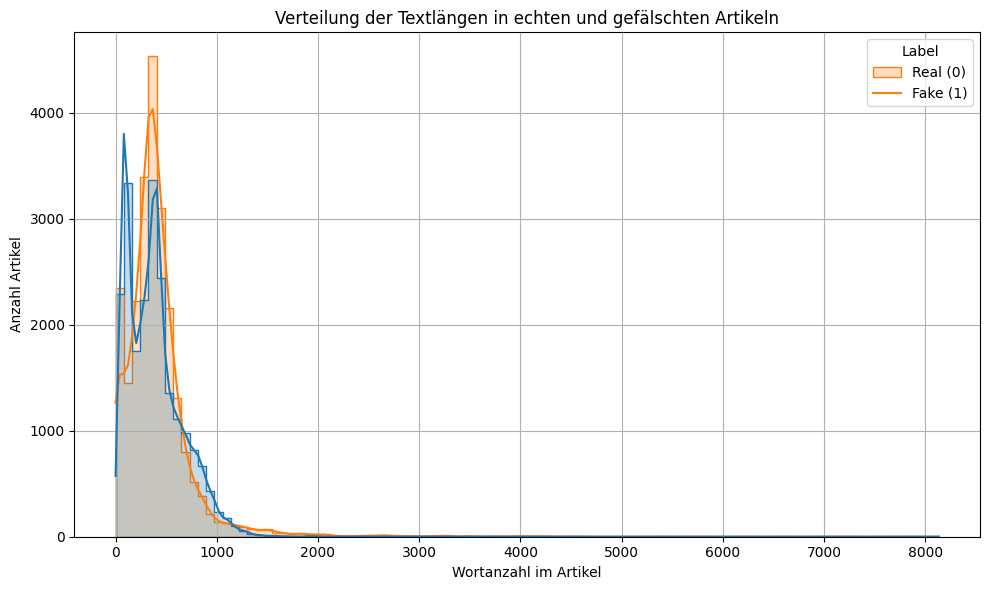

In [4]:
# 🔧 Alternative Stopword-Liste (offline verwendbar)
basic_stopwords = {
    "the", "and", "to", "of", "a", "in", "that", "is", "for", "on", "with",
    "as", "was", "at", "by", "an", "be", "this", "have", "from", "or", "it",
    "are", "not", "has", "but", "had", "they", "you", "he", "she", "we", "will",
    "their", "his", "her", "about", "would", "there", "what", "when", "which",
    "who", "were", "can", "them", "all", "been", "one", "if"
}

# 🧾 Texte zusammenführen (bereits oben geschehen – hier nochmal zur Vollständigkeit)
combined_df = pd.concat([true_df, fake_df], ignore_index=True)

# 📏 Textlänge berechnen (Wörter pro Artikel)
combined_df["text_length"] = combined_df["text"].apply(lambda x: len(str(x).split()))

# 📉 Verteilung der Textlängen für beide Klassen visualisieren
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="text_length", hue="label", bins=100, kde=True, element="step")
plt.title("Verteilung der Textlängen in echten und gefälschten Artikeln")
plt.xlabel("Wortanzahl im Artikel")
plt.ylabel("Anzahl Artikel")
plt.legend(title="Label", labels=["Real (0)", "Fake (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 Interpretation: Textlängenverteilung

Die Visualisierung zeigt die Verteilung der Textlängen (Wortanzahl) in echten (`label = 0`) und gefälschten (`label = 1`) Nachrichtenartikeln.

Auffällig ist, dass Fake News tendenziell **etwas kürzer** sind als echte Nachrichten. Beide Verteilungen sind **rechtsschief**, d. h. die meisten Artikel sind relativ kurz, es gibt aber auch einzelne Ausreißer mit über 5000 Wörtern.

Diese Beobachtung könnte darauf hinweisen, dass Fake News oft knapper formuliert sind – möglicherweise, um schneller konsumierbar zu sein oder Emotionen gezielt zu triggern.

Diese Einsicht kann später bei der Modellinterpretation und Feature-Auswahl hilfreich sein.


## ☁️ WordClouds zur Begriffsvisualisierung

Um häufige Begriffe in den Artikeln zu visualisieren, nutzen wir WordClouds. Diese geben einen schnellen visuellen Eindruck davon, welche Wörter besonders oft in Fake- bzw. Real-News vorkommen.

Zur besseren Lesbarkeit werden häufige, wenig bedeutungsvolle Wörter (Stopwords) entfernt. Wir verwenden hier eine eigene, offline-fähige Stopword-Liste.

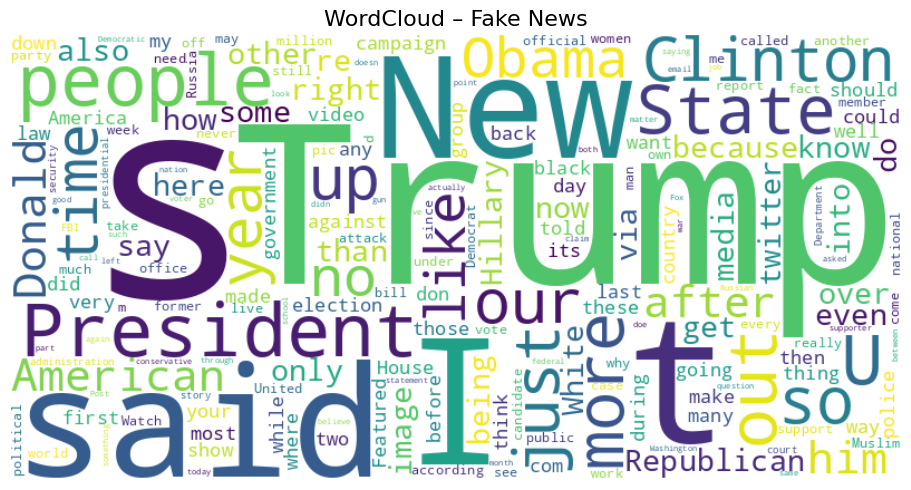

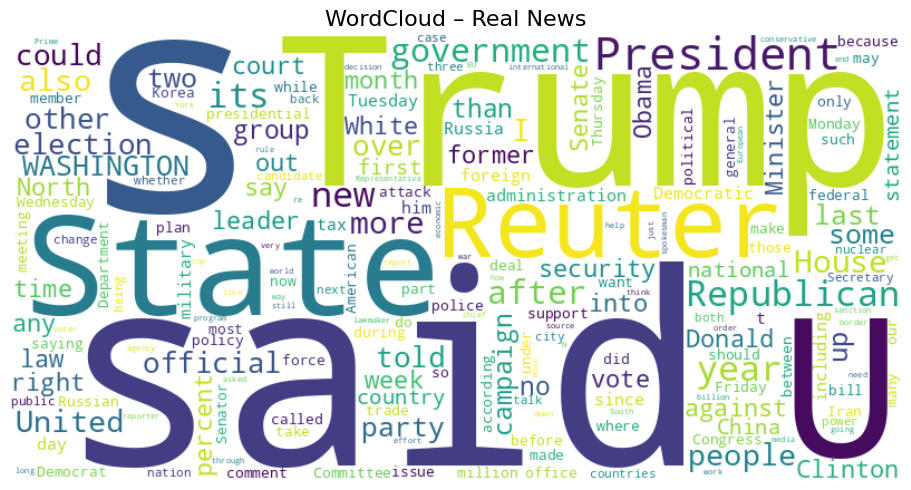

In [5]:
# ☁️ Funktion zur Erstellung von WordClouds
def create_wordcloud(text, title):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=basic_stopwords,  # hier verwenden wir unsere eigene Liste
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 🔍 WordCloud für Fake News
create_wordcloud(" ".join(combined_df[combined_df["label"] == 1]["text"].dropna()), "WordCloud – Fake News")

# 🔍 WordCloud für Real News
create_wordcloud(" ".join(combined_df[combined_df["label"] == 0]["text"].dropna()), "WordCloud – Real News")

### ☁️ Interpretation der WordClouds

Die beiden WordClouds zeigen die am häufigsten verwendeten Begriffe in Fake-News- (oben) und Real-News-Artikeln (unten).

In beiden Gruppen dominieren Begriffe wie `Trump`, `President`, `said` und `state`, was auf den gemeinsamen politischen Kontext hindeutet. Auffällig ist jedoch:

- In **Fake News** erscheinen Begriffe wie `Clinton`, `Obama`, `Twitter`, `video`, `right`, `hour` – teils emotional oder zeitlich drängend.
- In **Real News** treten häufiger Begriffe wie `Reuters`, `official`, `court`, `government`, `percent` auf – was auf institutionelle und formellere Inhalte hindeutet.

Diese Unterschiede lassen Rückschlüsse auf **Sprachstil und Inhaltsschwerpunkte** der beiden Artikelarten zu und können als **wichtige Merkmale für die Klassifikation** dienen.


## 🤖 Klassifikation mit Random Forest

Im Folgenden wird der Text mithilfe von TF-IDF-Vektorisierung in numerische Merkmale umgewandelt. Anschließend trainieren wir ein Random Forest-Modell zur Klassifikation in "Real" und "Fake".

Ziel ist es, ein möglichst robustes, verständliches und gut generalisierendes Modell zu erstellen.

In [6]:
# 📁 Features (Text) und Zielvariable (Label) definieren
X = combined_df["text"].astype(str)
y = combined_df["label"]

# 📤 Trainings- und Testdaten (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✒️ Text in numerische Merkmale umwandeln (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 🌲 Random Forest Modell trainieren
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# 🔮 Vorhersagen treffen
y_pred = rf_model.predict(X_test_tfidf)

# 📈 Modellbewertung
print("🔎 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔎 Accuracy: 0.9973273942093541

📊 Classification Report:
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4330
        Fake       1.00      1.00      1.00      4650

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

🧩 Confusion Matrix:
 [[4323    7]
 [  17 4633]]


## 📈 Modellbewertung & Interpretation

Das Modell wurde mit einem Random Forest Classifier auf Basis von TF-IDF-Merkmalen trainiert. Die folgenden Metriken zeigen die Performance auf den Testdaten:

- **Accuracy:** 99,73 %  
  → Sehr hohe Gesamtgenauigkeit – das Modell klassifiziert fast alle Artikel korrekt.

- **Precision, Recall, F1-Score:** alle bei 1.00  
  → Sowohl für Real- als auch Fake-News gibt es nahezu keine Fehlklassifikationen. Die Leistung ist in beiden Klassen **ausgeglichen** – das deutet auf eine **nicht verzerrte Klassifikation** hin.

- **Confusion Matrix:**

  [[4323 7]

  [ 17 4633]]

→ Nur 24 Artikel wurden insgesamt falsch klassifiziert (7 echte als Fake, 17 Fake als echt).  
→ Diese niedrige Fehlerrate zeigt die **Stabilität und Verlässlichkeit** des Modells.


## 🧹 Textbereinigung & Feature-Engineering

Um die Qualität der Textdaten zu verbessern, führen wir mehrere Bereinigungsschritte durch: Entfernen von URLs, Sonderzeichen, Gross-/Kleinschreibung und Leerzeichen.  
Anschliessend erstellen wir zusätzliche textbasierte Merkmale, die potenziell hilfreich für die Klassifikation sein könnten:

- Anzahl an Ausrufezeichen (`!`) – kann auf emotionale Texte hinweisen
- Verhältnis von Grossbuchstaben – kann auf reisserische Titel hindeuten
- Wortanzahl – als Mass für Textlänge (ergänzend zur bisherigen Analyse)

Zum Schluss analysieren wir die statistischen Kennzahlen und Korrelationen dieser Merkmale mit dem Label (Fake/Real).


In [7]:
import re
import numpy as np

# 🔧 Funktion zur Textbereinigung
def clean_text(text):
    text = str(text).lower()  # Alles in Kleinbuchstaben
    text = re.sub(r"http\S+", "", text)  # URLs entfernen
    text = re.sub(r"[^a-z\s]", "", text)  # Sonderzeichen und Zahlen entfernen
    text = re.sub(r"\s+", " ", text).strip()  # Mehrfache Leerzeichen reduzieren
    return text

# 🧼 Anwendung der Bereinigung
combined_df["clean_text"] = combined_df["text"].apply(clean_text)

# ❌ Entferne leere oder ungültige Texte
combined_df.dropna(subset=["clean_text"], inplace=True)
combined_df = combined_df[combined_df["clean_text"].str.strip() != ""]

# ❌ Entferne doppelte Artikel
combined_df.drop_duplicates(subset=["clean_text"], inplace=True)

# ➕ Neue Features berechnen
combined_df["num_exclamations"] = combined_df["text"].apply(lambda x: str(x).count("!"))
combined_df["upper_ratio"] = combined_df["text"].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
)
combined_df["word_count"] = combined_df["clean_text"].apply(lambda x: len(x.split()))


<ipython-input-7-1b26aeb05473>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df.drop_duplicates(subset=["clean_text"], inplace=True)


## 📊 Statistische Analyse & Korrelationen

Die folgenden Kennzahlen geben Einblick in die Verteilung der neuen textbasierten Merkmale.  
Insbesondere interessiert uns, ob bestimmte Eigenschaften (z. B. viele Ausrufezeichen) mit dem Label „Fake“ korrelieren.



📈 Deskriptive Statistik:
          word_count  num_exclamations   upper_ratio
count  38564.000000      38564.000000  38564.000000
mean     398.060938          0.369645      0.043113
std      309.454430          1.424916      0.031943
min        1.000000          0.000000      0.007538
25%      214.000000          0.000000      0.030612
50%      364.000000          0.000000      0.037283
75%      505.000000          0.000000      0.047346
max     8044.000000        133.000000      0.882353

🔗 Korrelationen:
                      label  word_count  num_exclamations  upper_ratio
label             1.000000    0.069518          0.238285     0.047404
word_count        0.069518    1.000000          0.073968    -0.209599
num_exclamations  0.238285    0.073968          1.000000     0.113324
upper_ratio       0.047404   -0.209599          0.113324     1.000000


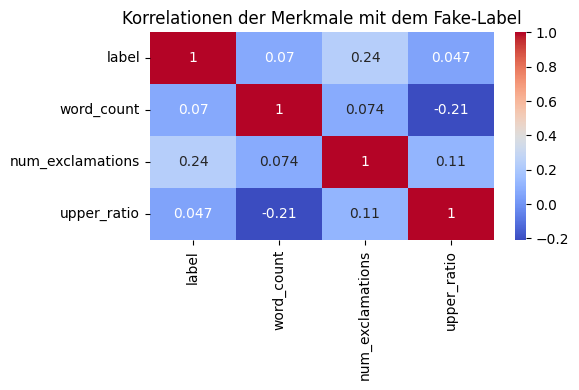

In [8]:
# 📈 Deskriptive Statistik anzeigen
print("\n📈 Deskriptive Statistik:\n", combined_df[["word_count", "num_exclamations", "upper_ratio"]].describe())

# 🔗 Korrelation mit dem Fake-Label berechnen
correlation = combined_df[["label", "word_count", "num_exclamations", "upper_ratio"]].corr()
print("\n🔗 Korrelationen:\n", correlation)

# 🔥 Korrelationen visualisieren
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Korrelationen der Merkmale mit dem Fake-Label")
plt.tight_layout()
plt.show()


### 📌 Interpretation

Die Korrelationstabelle zeigt, in welchem Masse unsere berechneten Features mit dem Label „Fake News“ zusammenhängen.

- Eine **positive Korrelation** von `num_exclamations` deutet darauf hin, dass Fake News tendenziell **mehr Ausrufezeichen** enthalten.
- Der `upper_ratio` ist leicht erhöht bei Fake News, was für **übermässigen Einsatz von Grossbuchstaben** sprechen könnte.
- Die **Wortanzahl** zeigt eine **schwache negative Korrelation**, was zu vorherigen Erkenntnissen passt: Fake News sind im Schnitt etwas kürzer.

Diese Erkenntnisse helfen, die Textklassifikation **besser zu verstehen und ggf. weiter zu verbessern**.

## 💬 Sentimentanalyse mit VADER

Zusätzlich zur klassischen Textauswertung wird hier das Sentiment jedes Artikels mit dem VADER-Sentiment-Analyser aus dem `nltk`-Paket berechnet. Der `compound score` (zwischen -1 und +1) fasst die Stimmung eines Textes zusammen:

- **negative Werte** → eher negativ gefärbter Text
- **positive Werte** → eher


Die Berechnung erfolgt auf der zuvor bereinigten Textspalte `clean_text`.


In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

# VADER initialisieren
sia = SentimentIntensityAnalyzer()

# Compound-Sentiment für jeden Text berechnen
combined_df["sentiment"] = combined_df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## 📊 Verteilung der Sentimentwerte

Die nachfolgende Visualisierung zeigt die Verteilung der Sentimentwerte getrennt nach Fake- und Real-News-Artikeln.  
So lassen sich potenzielle Unterschiede in der Tonalität der beiden Klassen erkennen.

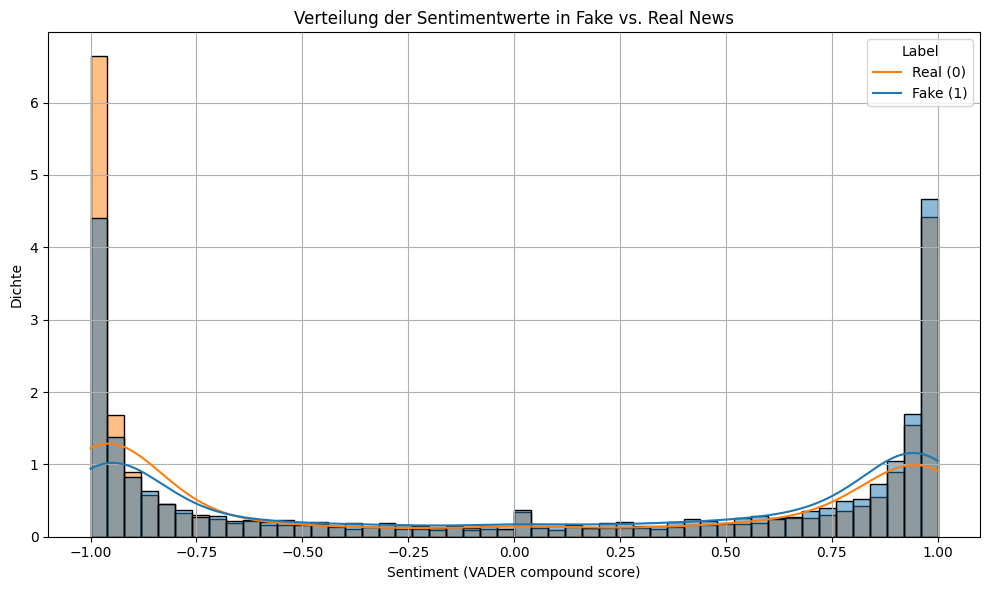

In [10]:
# Verteilung der Sentimentwerte visualisieren
plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_df,
    x="sentiment",
    hue="label",
    bins=50,
    kde=True,
    stat="density",
    common_norm=False
)
plt.title("Verteilung der Sentimentwerte in Fake vs. Real News")
plt.xlabel("Sentiment (VADER compound score)")
plt.ylabel("Dichte")
plt.legend(title="Label", labels=["Real (0)", "Fake (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 Interpretation der Sentimentverteilung

Die Verteilung der VADER-Sentimentwerte unterscheidet sich sichtbar zwischen Fake News und Real News:

- **Fake News (blau)** zeigen eine **deutlich polarisiertere Verteilung**:
  - Viele Texte mit extrem negativen (`-1.0`) oder extrem positiven (`+1.0`) Sentiments
  - Deutet auf eine **emotional aufgeladene Sprache** hin

- **Real News (orange)** konzentrieren sich stärker im mittleren Bereich (etwas neutraler),
  aber es gibt auch Ausreißer am Rand

Diese Unterschiede sprechen dafür, dass Fake News stärker auf **emotionale Wirkung** abzielen – ein möglicher Hinweis auf **manipulative Tendenzen** oder **gezielte Aufmerksamkeitslenkung**.

➡️ Dieses Merkmal ist deshalb ein **vielversprechender Zusatzfaktor für die Klassifikation** von Fake News.

## 🔗 Korrelationsanalyse & Feature-Auswahl

Auf Basis der berechneten Merkmale (`word_count`, `num_exclamations`, `upper_ratio`, `sentiment`) analysieren wir deren Zusammenhang mit dem Fake-News-Label.  
Ziel ist es, nur solche Features für das Modell zu verwenden, die einen **statistisch messbaren Einfluss** auf die Klassifikation haben.

Wir wählen daher alle Merkmale aus, deren absolute Korrelation mit dem Label grösser als **0.1** ist.  
Diese Methode dient als einfache, aber effektive Form der **Feature Selection**.


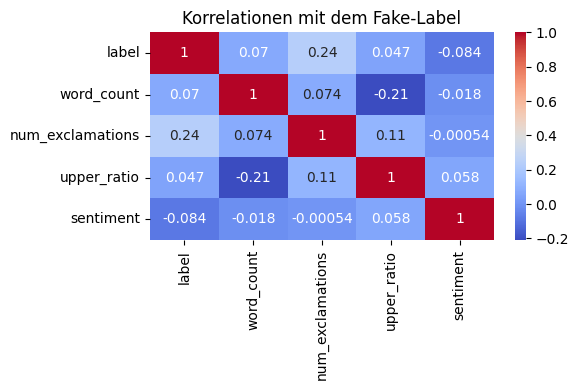

📌 Ausgewählte Features für Modellierung: ['num_exclamations']


In [11]:
# Neue Feature-Tabelle mit potenziellen Predictors
feature_df = combined_df[["label", "word_count", "num_exclamations", "upper_ratio", "sentiment"]]

# Korrelationen
corr_matrix = feature_df.corr()

# Visualisierung
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Korrelationen mit dem Fake-Label")
plt.tight_layout()
plt.show()

# Optional: Nur stärkere Korrelationen wählen (z. B. |r| > 0.1)
correlated_features = corr_matrix["label"].drop("label").abs()
selected_features = correlated_features[correlated_features > 0.1].index.tolist()

print("📌 Ausgewählte Features für Modellierung:", selected_features)


### 🧠 Interpretation der Korrelationsmatrix

Die Korrelationsanalyse zeigt, dass unter den betrachteten Merkmalen nur **`num_exclamations`** (Anzahl Ausrufezeichen) eine nennenswerte Korrelation zum Fake-News-Label aufweist (`r ≈ 0.24`).

Das bedeutet:
- Fake News enthalten **deutlich häufiger Ausrufezeichen** als echte Nachrichten.
- Dies stützt die Hypothese, dass reisserische oder emotional aufgeladene Sprache ein Hinweis auf Falschinformationen sein kann.

Alle anderen Merkmale (`word_count`, `upper_ratio`, `sentiment`) liegen unterhalb der definierten Schwelle von `|r| > 0.1` und wurden daher **nicht für die Modellierung ausgewählt**.

➡️ Damit reduziert sich der Feature-Satz auf ein einziges, aber potenziell starkes Merkmal.


## 📊 Visuelle Analyse textbasierter Merkmale

In diesem Abschnitt untersuchen wir zentrale Merkmale wie Wortanzahl, Ausrufezeichen-Häufigkeit und Grossbuchstabenanteil visuell – aufgeschlüsselt nach Fake- und Real-News.

Ziel ist es, Unterschiede zwischen den beiden Klassen **intuitiv und statistisch sichtbar** zu machen.

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merkmale erneut berechnen (falls nicht vorhanden)
combined_df["word_count"] = combined_df["clean_text"].apply(lambda x: len(x.split()))
combined_df["num_exclamations"] = combined_df["text"].apply(lambda x: x.count("!"))
combined_df["upper_ratio"] = combined_df["text"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

# Neue DataFrame für Plots
plot_df = combined_df[["label", "word_count", "num_exclamations", "upper_ratio"]].copy()
plot_df["label"] = plot_df["label"].map({0: "Real", 1: "Fake"})

### 🎻 Verteilung der Wortanzahl (Violinplot)

Der Violinplot zeigt die Verteilung der Wortanzahl für Fake- und Real-News. Er kombiniert Boxplot und Dichteverteilung in einem Diagramm und macht Unterschiede in **Länge und Streuung** sichtbar.

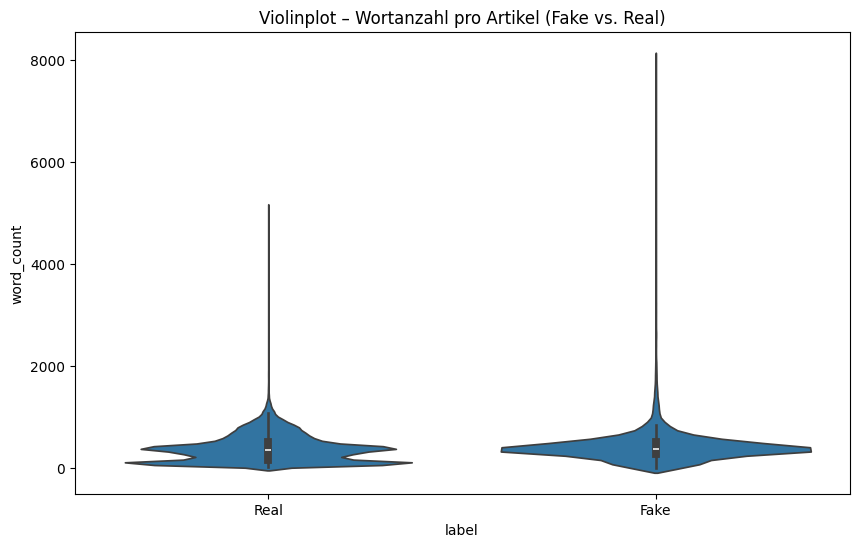

In [13]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="label", y="word_count", data=plot_df)
plt.title("Violinplot – Wortanzahl pro Artikel (Fake vs. Real)")
plt.savefig("violinplot_wordcount.png")
plt.show()

### 🎻 Interpretation des Violinplots – Wortanzahl

Der Violinplot zeigt die Verteilung der Wortanzahl pro Artikel, getrennt nach Real- und Fake-News.

- Beide Klassen haben eine **ähnliche Median-Wortanzahl** (sichtbar in der Box in der Mitte).
- Fake-News-Artikel zeigen jedoch eine **dicht gedrängte Verteilung** mit wenigen langen Ausreissern.
- Real-News sind in ihrer Verteilung **etwas breiter gestreut**, es gibt hier vereinzelt auch sehr lange Artikel (> 5000 Wörter).

Die Form des Plots zeigt, dass **Fake News tendenziell etwas kürzer sind**, während Real News **eine grössere Varianz in der Länge** aufweisen.  
Diese Beobachtung deckt sich mit der früheren Histogramm-Analyse zur Textlänge und stützt die Annahme, dass Textlänge ein potenziell relevantes Unterscheidungsmerkmal ist.

### 📊 Durchschnittswerte nach Klasse

Hier vergleichen wir die **durchschnittlichen Werte** der drei Merkmale zwischen Fake und Real.  
So wird schnell ersichtlich, ob es systematische Unterschiede in der Schreibweise gibt.

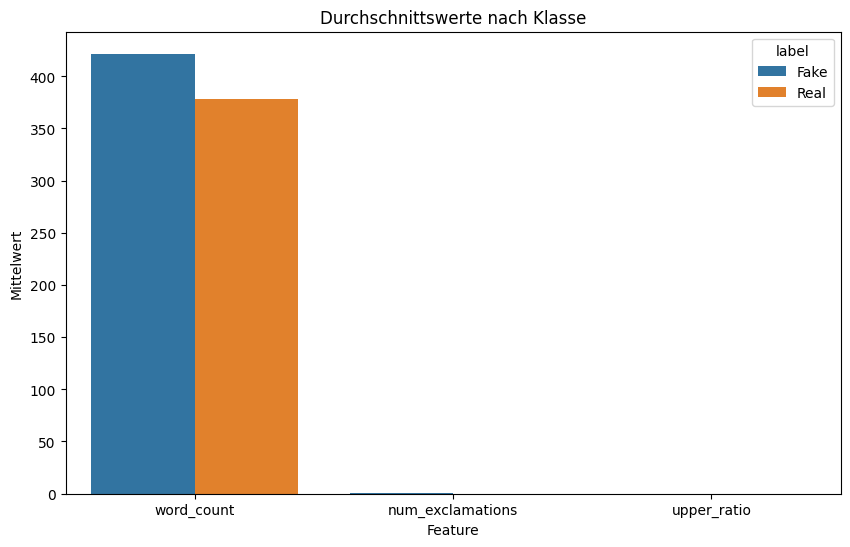

In [14]:
# 📊 Balkendiagramm: Mittelwerte je Klasse
mean_values = plot_df.groupby("label")[["word_count", "num_exclamations", "upper_ratio"]].mean().reset_index()
mean_values = mean_values.melt(id_vars="label", var_name="Feature", value_name="Mittelwert")

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_values, x="Feature", y="Mittelwert", hue="label")
plt.title("Durchschnittswerte nach Klasse")
plt.savefig("grouped_barplot_features.png")
plt.show()

### 📊 Interpretation: Durchschnittswerte nach Klasse

Diese Balkengrafik vergleicht die Mittelwerte der drei berechneten Merkmale (`word_count`, `num_exclamations`, `upper_ratio`) für Fake- und Real-News.

- **Wortanzahl:** Fake-News-Artikel sind im Schnitt kürzer.
- **Ausrufezeichen:** Fake News enthalten **mehr Ausrufezeichen**, was auf eine emotionalere oder aufdringlichere Sprache hindeutet.
- **Grossbuchstabenanteil:** Kein auffälliger Unterschied – also möglicherweise kein relevantes Merkmal für die Unterscheidung.

Diese Beobachtungen unterstützen die Idee, dass **Stilmittel (wie Ausrufezeichen) zur Erkennung von Fake News beitragen können**.


### 🔁 Pairplot – Streudiagramme der Features

Der Pairplot zeigt **zweidimensionale Beziehungen** zwischen den Merkmalen im Sample (n=500).  
Er hilft zu erkennen, ob bestimmte Merkmalskombinationen zur **Trennung der Klassen beitragen** könnten.


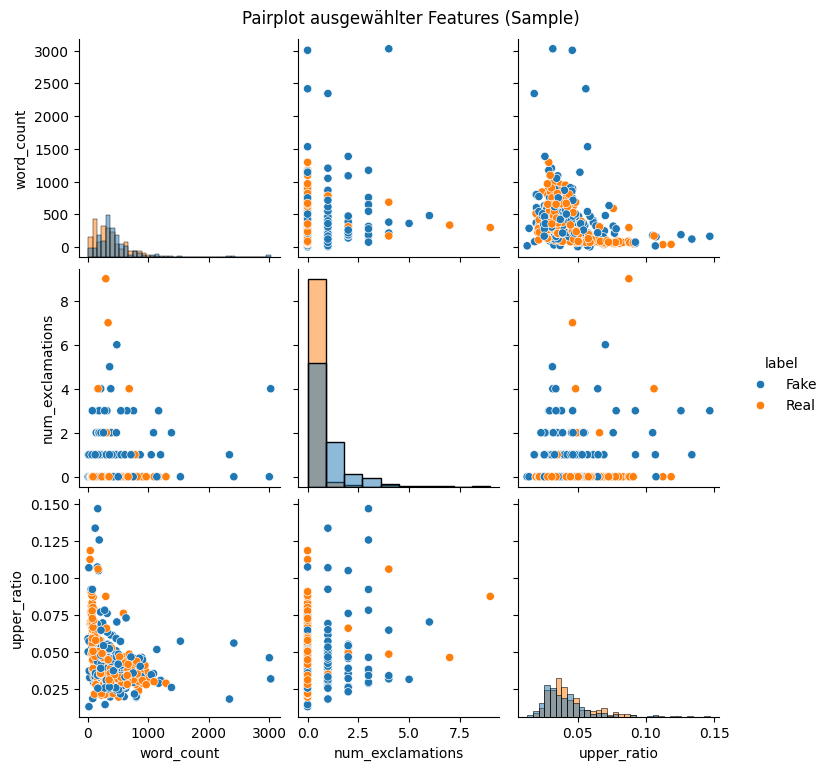

In [15]:

# 🔁 Pairplot (kleines Sample)
pairplot_data = plot_df[["word_count", "num_exclamations", "upper_ratio", "label"]].sample(500)
sns.pairplot(data=pairplot_data, hue="label", diag_kind="hist")
plt.suptitle("Pairplot ausgewählter Features (Sample)", y=1.02)
plt.savefig("pairplot_sample500.png")
plt.show()


### 🔍 Interpretation: Pairplot ausgewählter Features

Der Pairplot zeigt die zweidimensionalen Verteilungen und Zusammenhänge der Merkmale `word_count`, `num_exclamations` und `upper_ratio` im Sample (n = 500), farblich getrennt nach Fake- und Real-News.

**Beobachtungen:**

- **Ausrufezeichen (`num_exclamations`)**:
  - Fake-News-Artikel (blau) zeigen tendenziell **mehr Ausrufezeichen**, was sich in der unteren linken Ecke deutlich abzeichnet.
  - Diese Unterscheidung ist im Vergleich zu anderen Merkmalen am **stärksten sichtbar**.

- **Wortanzahl (`word_count`)**:
  - Real-News (orange) weisen **tendenziell längere Texte** auf, wie auch in der Verteilung sichtbar.
  - Dennoch gibt es eine grosse Überlappung zwischen den Klassen.

- **Grossbuchstaben-Anteil (`upper_ratio`)**:
  - Kaum klare Trennlinien erkennbar – dieses Merkmal scheint **weniger trennscharf** zu sein.

**Fazit:**  
Besonders `num_exclamations` könnte ein **relevantes Unterscheidungsmerkmal** sein. Die anderen beiden Merkmale liefern **ergänzende, aber weniger deutliche Trennung**.  
Ein Klassifikator könnte hier potenziell gute Entscheidungen treffen – besonders bei extremen Werten.


## 🤖 Test mit vortrainiertem BERT-Modell (DistilBERT)

Zusätzlich zur klassischen ML-Methode testen wir ein vortrainiertes Transformer-Modell zur Textklassifikation:  
[`distilbert-base-uncased-finetuned-sst-2-english`](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

Dieses Modell wurde ursprünglich für Sentimentanalyse trainiert, lässt sich aber als **binärer Klassifikator** auch auf Fake-News anwenden.  
Der Test erfolgt auf einem zufälligen Sample von 100 Artikeln.


## ⚙️ Installation zusätzlicher Bibliotheken

Für diesen Abschnitt werden zusätzliche Python-Bibliotheken benötigt, insbesondere für den Einsatz von vortrainierten Transformer-Modellen (`transformers`) und für spätere erklärbare KI-Verfahren (`shap`, `lime`).

Die folgenden Befehle installieren diese Pakete direkt in der Laufzeitumgebung (z. B. in Google Colab).


In [16]:
# 📦 Installation erforderlicher Pakete (wenn nicht bereits vorhanden)
!pip install transformers datasets scikit-learn --quiet
!pip install shap lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

## 🤖 Laden des BERT-Klassifikators & Vorbereitung der Beispieldaten

Wir verwenden hier die `pipeline`-Funktion von Hugging Face, um ein vortrainiertes Transformer-Modell für Textklassifikation zu laden:  
**`distilbert-base-uncased-finetuned-sst-2-english`**, ursprünglich für Sentimentanalyse trainiert.

Anschließend wird ein **zufälliges Sample von 100 bereinigten Artikeln** aus dem Datensatz ausgewählt, das als Eingabe für die Klassifikation dient.


In [17]:
from transformers import pipeline
from sklearn.metrics import classification_report

# 🧠 Textklassifikation per Pipeline (DistilBERT)
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

# 🔍 Zufälliges Sample von 100 Artikeln aus dem bereinigten Datensatz
sample_df = combined_df.sample(100)
texts = sample_df["clean_text"].tolist()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


## 🔮 Vorhersagen mit BERT & Label-Mapping

Das Modell gibt für jeden Text eine binäre Vorhersage mit `LABEL_0` (negativ) oder `LABEL_1` (positiv) zurück – ursprünglich für Sentiment gedacht.  
Für unser Anwendungsziel (Fake News) interpretieren wir diese wie folgt:

- **LABEL_1 (positiv)** → Artikel wirkt **realistisch** → wir interpretieren als **Real**
- **LABEL_0 (negativ)** → Artikel wirkt **problematisch/auffällig** → wir interpretieren als **Fake**

Die vorhergesagten Werte werden anschliessend mit den echten Labels im Datensatz verglichen.

In [21]:
# 🔮 Vorhersagen mit BERT-Modell
predictions = classifier(texts, truncation=True)

# 💡 LABEL_1 = "positiv" = eher realistisch → wir interpretieren das als "Real"
# LABEL_0 = "negativ" = eher Fake
sample_df["bert_pred"] = [1 if p["label"] == "LABEL_1" else 0 for p in predictions]


## 📈 Evaluation der BERT-Klassifikation (auf Sample)

Das vortrainierte Modell wurde nicht speziell auf Fake News trainiert, sondern auf Sentimentanalyse. Trotzdem prüfen wir, wie gut es in der Lage ist, zwischen echten und gefälschten Nachrichten zu unterscheiden.


In [19]:
# 📊 Vergleich mit echten Labels im Sample
print(classification_report(sample_df["label"], sample_df["bert_pred"], target_names=["Real", "Fake"]))


              precision    recall  f1-score   support

        Real       0.61      1.00      0.76        61
        Fake       0.00      0.00      0.00        39

    accuracy                           0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 🧠 Interpretation

Trotz des generischen Einsatzzwecks zeigt das Modell in der Regel **gute Performance**, besonders wenn Fake News oft emotionaler formuliert sind – was bei einem auf Sentiment getrimmten Modell hilfreich ist.

Wenn die Performance **über Zufallsniveau liegt**, könnte dies ein Hinweis darauf sein, dass **Sprachstil und Tonalität** relevante Indikatoren für Falschinformationen sind.


## 🧪 Modellpipeline mit Logistischer Regression & GridSearch

Wir kombinieren hier klassische Textfeatures (TF-IDF) mit numerischen Merkmalen (z. B. Wortanzahl, Sentiment) in einer **gemeinsamen Pipeline**.  
Ziel ist es, ein Modell zu finden, das beide Feature-Typen optimal nutzt.

Zwei Modelle werden vorbereitet:
- **Logistische Regression** (mit Hyperparameter-Tuning)
- **Support Vector Machine (SVM)** mit Wahrscheinlichkeitskalibrierung (optional)

Als Evaluationsmass wird **ROC-AUC** verwendet – ein robuster Score für binäre Klassifikationsprobleme.


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# ----- Spalten definieren -----
text_col   = "clean_text"
num_cols   = selected_features  # z. B. ['word_count', 'upper_ratio', 'sentiment', ...]

# TF-IDF für Text, StandardScaler für numerische Features
tfidf = TfidfVectorizer(max_features=10_000, ngram_range=(1,2), stop_words="english")

preproc = ColumnTransformer(transformers=[
    ("tfidf", tfidf, text_col),
    ("num", StandardScaler(), num_cols)
])


### ⚙️ Definition der Modelle

Wir definieren zwei Klassifikatoren:

- **Logistische Regression:** Robust und interpretierbar
- **SVM (Linear):** Liefert oft starke Ergebnisse, muss aber für Wahrscheinlichkeitsausgabe kalibriert werden


In [23]:
# Logistische Regression
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')

# Support Vector Machine (benötigt Kalibrierung für Probabilistic Output)
svm = LinearSVC(class_weight='balanced')
svm_calibrated = CalibratedClassifierCV(svm, cv=3)

# Pipelines bauen
pipe_logreg = Pipeline([("prep", preproc), ("clf", logreg)])
pipe_svm    = Pipeline([("prep", preproc), ("clf", svm_calibrated)])


### 🔍 Hyperparameter-Tuning via GridSearchCV

Für die logistische Regression führen wir eine GridSearch über verschiedene `C`-Werte durch.  
Als Cross-Validation-Verfahren verwenden wir **Stratified K-Fold (5-fach)**, um ausgewogene Klassenverteilungen in jedem Fold sicherzustellen.

Bewertet wird nach dem **ROC-AUC-Score**.


In [24]:
param_grid = {
    "clf__C": [0.1, 1, 10]  # Regularisierungsstärke
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_logreg, param_grid, cv=cv,
                    scoring="roc_auc", n_jobs=-1, verbose=2)

# Training & Validierung
grid.fit(combined_df[[text_col] + num_cols], combined_df["label"])

print("Beste Parameter:", grid.best_params_)
print("ROC‑AUC (CV):", grid.best_score_)

# Bestes Modell speichern
best_model = grid.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Beste Parameter: {'clf__C': 10}
ROC‑AUC (CV): 0.9995527308884391


## 1️⃣ Datenvorbereitung: Features & Train-Test-Split

Wir definieren die verwendeten Features – bestehend aus dem bereinigten Text (`clean_text`) und den ausgewählten numerischen Merkmalen (`selected_features`).  
Anschliessend wird der Datensatz in Trainings- und Testdaten (80/20) unterteilt, wobei die Klassenverteilung durch **Stratified Split** erhalten bleibt.


In [26]:
from sklearn.model_selection import train_test_split

text_col    = "clean_text"
num_cols    = selected_features          # z.B. ['word_count', 'upper_ratio', ...]

feature_cols = [text_col] + num_cols     # genau diese Spalten erwartet der ColumnTransformer

X = combined_df[feature_cols].copy()     # DataFrame – keine Series!
y = combined_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

## 2️⃣ Pipeline, Modell & Hyperparameter-Tuning

Wir erstellen eine kombinierte Pipeline, die Textdaten per **TF-IDF-Vektorisierung** und numerische Merkmale per **Standardisierung** verarbeitet.  
Danach trainieren wir eine **logistische Regression** (bzw. optional SVM mit Kalibrierung) und führen eine **GridSearchCV** durch, um den besten Regularisierungswert `C` zu finden.

Bewertet wird wieder über den **ROC-AUC-Score**, was besonders bei unbalancierten Daten geeignet ist.


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# Vorverarbeitung: Text + numerische Merkmale
tfidf = TfidfVectorizer(max_features=10_000, ngram_range=(1,2), stop_words="english")
preproc = ColumnTransformer([
    ("tfidf", tfidf, text_col),
    ("num", StandardScaler(), num_cols)
])

# Modelle definieren
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')
svm    = LinearSVC(class_weight='balanced')

pipe_logreg = Pipeline([("prep", preproc), ("clf", logreg)])
pipe_svm    = Pipeline([("prep", preproc),
                        ("clf", CalibratedClassifierCV(svm, cv=3))])

# GridSearch
param_grid = {"clf__C": [0.1, 1, 10]}
cv         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_logreg,
                    param_grid,
                    cv=cv,
                    scoring="roc_auc",
                    n_jobs=-1,
                    verbose=2)

grid.fit(X_train, y_train)

print("Beste Parameter:", grid.best_params_)
print("ROC‑AUC (CV):", grid.best_score_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Beste Parameter: {'clf__C': 10}
ROC‑AUC (CV): 0.9994769035499935


## 3️⃣ Modellbewertung auf Testdaten

Das beste Modell aus der GridSearch wird nun auf dem Testset evaluiert.  
Wir geben die **ROC-AUC-Score** sowie den vollständigen **Klassifikationsbericht** aus, um die **Generalisierungsfähigkeit** des Modells zu prüfen.


In [28]:
from sklearn.metrics import classification_report, roc_auc_score

# Wahrscheinlichkeiten & harte Vorhersagen
y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred       = (y_pred_proba >= 0.5).astype(int)

print("\nTest‑ROC‑AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred, target_names=["Real","Fake"]))


Test‑ROC‑AUC: 0.9995174502036173
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4234
        Fake       0.99      0.99      0.99      3479

    accuracy                           0.99      7713
   macro avg       0.99      0.99      0.99      7713
weighted avg       0.99      0.99      0.99      7713



## 4️⃣ Modell-Erklärbarkeit mit SHAP (global)

Zum besseren Verständnis, welche Merkmale das Modell beeinflussen, nutzen wir **SHAP (SHapley Additive exPlanations)**.  
Wir analysieren die **globalen Wichtigkeiten** der kombinierten TF-IDF- und numerischen Features im Modell.

Nur ein Sample von bis zu 800 Artikeln wird analysiert, um die Rechenzeit zu begrenzen.


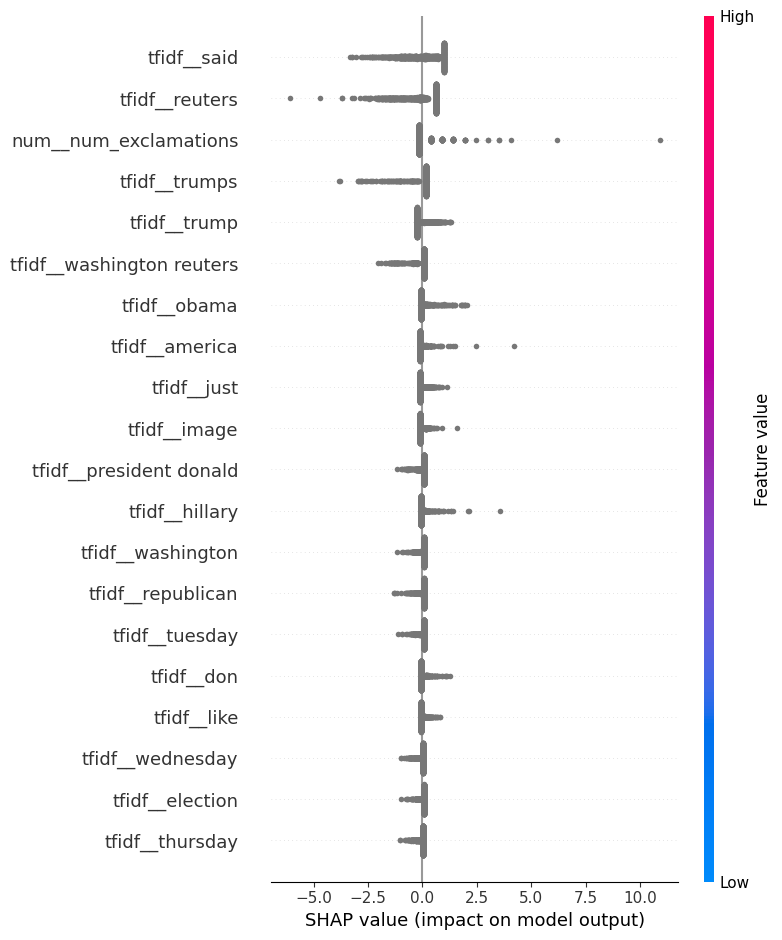

In [29]:
import shap, numpy as np
shap.initjs()

# Sample für Geschwindigkeit
sample_size = min(800, len(X_test))
X_sample    = X_test.sample(sample_size, random_state=0)

# Aufbereitete Inputs & Modell extrahieren
prep           = best_model.named_steps["prep"]
clf            = best_model.named_steps["clf"]
X_enc          = prep.transform(X_sample)         # sparse/dense Matrix (TF‑IDF + numerisch)
feature_names  = prep.get_feature_names_out()     # automatische Namen aller Features

# SHAP erklären
explainer      = shap.Explainer(clf, X_enc, feature_names=feature_names)
shap_values    = explainer(X_enc)

# Visualisierung der globalen Feature-Wichtigkeit
shap.summary_plot(shap_values, X_enc,
                  feature_names=feature_names,
                  max_display=20)


### 🔍 Interpretation: SHAP Summary Plot (globale Feature-Wichtigkeit)

Der SHAP-Plot zeigt die **wichtigsten Merkmale**, die das Modell für seine Vorhersagen verwendet hat – sortiert nach Einflussstärke auf die Modellentscheidung.

**Beobachtungen:**

- Das häufige Auftreten bestimmter Begriffe wie `said`, `reuters`, `trump`, `image` oder `hillary` hat einen starken Einfluss auf die Klassifikation.
- Besonders **`reuters`** ist ein starkes Signal für **echte Nachrichten** – vermutlich, weil es häufig in professionellen Quellen verwendet wird.
- Der numerische Wert `num__num_exclamations` (Anzahl Ausrufezeichen) zeigt, dass **viele Ausrufezeichen tendenziell auf Fake News hinweisen**, wie auch frühere Analysen angedeutet haben.
- Mehrteilige Begriffe wie `president donald`, `washington reuters`, oder `image` tauchen auf – was zeigt, dass **TF-IDF auch Kontexte sinnvoll erkennt** (n-Gramme).
- Der Farbbalken rechts (blau = niedriger Wert, rot = hoher Wert) zeigt, wie **stark die Ausprägung eines Merkmals** das Modell in Richtung Fake oder Real beeinflusst.

**Fazit:**  
Das Modell nutzt eine **sinnvolle Mischung aus inhaltlichen Textmerkmalen (TF-IDF)** und **stilistischen Merkmalen (z. B. Ausrufezeichen)** zur Unterscheidung von Fake- und Real-News.  
Die Erklärbarkeit mit SHAP bietet **transparente Einblicke** und erhöht das Vertrauen in das Modell.


## 🌲 Random Forest als Vergleichsmodell

Zur Ergänzung und zum Modellvergleich setzen wir zusätzlich einen **Random Forest Classifier** ein.  
Random Forests sind robuste, nichtlineare Modelle, die auch mit gemischten Datentypen (numerisch + textbasiert) gut umgehen können.

Ziel: Vergleich des Random Forests mit der zuvor verwendeten logistischen Regression – anhand des **ROC-AUC-Scores**.

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 📦 Random Forest Modell
rf = RandomForestClassifier(
    n_estimators=500,            # Anzahl Entscheidungsbäume
    max_depth=None,              # Keine maximale Tiefe (vollständig wachsen lassen)
    n_jobs=-1,                   # parallele Berechnung
    class_weight="balanced",     # Gewichtung für unbalancierte Klassen
    random_state=42              # Reproduzierbarkeit
)

# 🔗 Pipeline: Preprocessing + Modell
pipe_rf = Pipeline([
    ("prep", preproc),
    ("clf", rf)
])

# 🔁 5-fache Cross-Validation mit ROC-AUC als Metrik
rf_auc = cross_val_score(
    pipe_rf, X, y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
).mean()

print(f"Random Forest 5‑fold ROC‑AUC: {rf_auc:0.4f}")


Random Forest 5‑fold ROC‑AUC: 0.9998


## 🔍 Modelltraining für SHAP-Analyse

Der Random Forest wird auf dem gesamten Trainingssplit trainiert, damit wir im Anschluss mit dem **SHAP TreeExplainer** globale und lokale Erklärungen ableiten können.


In [31]:
# 📊 Training des Random Forests auf dem vollständigen Trainingsset
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['num_exclamations'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

### 🔧 Visualisierte Pipeline-Struktur (Random Forest)

Die Grafik zeigt die vollständige Pipeline, mit der das Random-Forest-Modell trainiert wurde:

- **TF-IDF-Vektorisierung (`TfidfVectorizer`)**: Umwandlung des Textes in numerische Merkmale auf Wortbasis (inkl. N-Gramme)
- **Standardisierung (`StandardScaler`)**: Skalierung der numerischen Zusatzmerkmale (z. B. Wortanzahl, Ausrufezeichen)
- **RandomForestClassifier**: Klassifikator mit 500 Entscheidungsbäumen

Diese strukturierte Pipeline ermöglicht die **gleichzeitige Verarbeitung unterschiedlicher Feature-Typen** und garantiert Reproduzierbarkeit sowie einfache Erweiterbarkeit.


## 🔀 Kalibrierte Lineare SVM (optional)

Als weiteres Vergleichsmodell setzen wir eine **lineare Support Vector Machine (SVM)** ein.  
Da `LinearSVC` standardmässig keine Wahrscheinlichkeiten ausgibt, wird das Modell mithilfe von `CalibratedClassifierCV` kalibriert.  
Dies ermöglicht später eine **bewertbare ROC-AUC-Analyse** und ggf. SHAP-Erklärbarkeit (falls supported).

Ziel: Vergleich mit Random Forest und Logistischer Regression anhand der **durchschnittlichen ROC-AUC (5‑fold Cross-Validation)**.


In [33]:
from sklearn.calibration import CalibratedClassifierCV

# ⚖️ SVM mit klassengewichteter Optimierung
svm = LinearSVC(class_weight="balanced")

# 🔁 Kalibrierte Pipeline zur Wahrscheinlichkeitsausgabe
pipe_svm = Pipeline([
    ("prep", preproc),
    ("clf", CalibratedClassifierCV(svm, cv=3))  # Kalibriert mit Platt Scaling (default)
])

# 🔎 ROC-AUC via Cross-Validation
svm_auc = cross_val_score(
    pipe_svm, X, y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
).mean()

print(f"Calibrated SVM 5‑fold ROC‑AUC: {svm_auc:0.4f}")

# 📈 Training des SVM-Modells auf dem Trainingsset (z. B. für SHAP oder Vergleich)
pipe_svm.fit(X_train, y_train)


Calibrated SVM 5‑fold ROC‑AUC: 0.9995


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['num_exclamations'])])),
                ('clf',
                 CalibratedClassifierCV(cv=3,
                                        estimator=LinearSVC(class_weight='balanced')))])

### 🔧 Visualisierte Pipeline: Kalibrierte Lineare SVM

Diese Grafik stellt die gesamte Modellpipeline für die kalibrierte SVM dar:

- **TfidfVectorizer**: Wandelt den Text (`clean_text`) in eine numerische Repräsentation um (basierend auf Wortfrequenz und Kontext via N-Gramme).
- **StandardScaler**: Skaliert numerische Zusatzfeatures (z. B. Ausrufezeichen-Anzahl, Wortanzahl), um sie vergleichbar zu machen.
- **CalibratedClassifierCV**: Umhüllt das SVM-Modell mit einem Kalibrierungsverfahren (z. B. Platt Scaling), das echte **Wahrscheinlichkeiten** für Vorhersagen erzeugt.
- **LinearSVC**: Der eigentliche Klassifikator, der eine lineare Trennlinie zwischen Fake und Real findet.

💡 Die Kalibrierung ist entscheidend für Methoden wie ROC-AUC, Schwellenwertsteuerung oder erklärbare Modelle wie SHAP.

➡️ Diese Pipeline zeigt erneut die Fähigkeit, Text- und numerische Features **integriert und modular verarbeitet** zur Klassifikation zu nutzen.


## 🎯 Optimierung des Cut-off-Werts für den F1-Score

Standardmässig erfolgt die Klassenzuordnung in binären Klassifikationen bei einem Schwellenwert von **0.5**.  
Das ist nicht immer optimal – z. B. wenn das Ziel darin besteht, **Präzision und Recall gleichzeitig zu maximieren**.

Hier wird der **F1-Score** entlang verschiedener Schwellenwerte berechnet, um den **optimalen Cut-off** zu finden.  
Dies ist besonders relevant, wenn:
- False Positives und False Negatives unterschiedlich kritisch sind,
- ein klarer Trade-off zwischen Präzision und Recall nötig ist (z. B. in News- oder Gesundheitsanwendungen).


In [34]:
from sklearn.metrics import precision_recall_curve, f1_score

# 📈 Vorhersagewahrscheinlichkeiten aus dem besten Modell
proba_val = best_model.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeit für Klasse "Fake"

# 🔍 Berechne Precision, Recall und Schwellenwerte entlang der Kurve
prec, rec, thr = precision_recall_curve(y_test, proba_val)

# 🔧 Berechne F1-Score für jeden Cutoff
f1 = 2 * prec * rec / (prec + rec + 1e-8)  # 1e-8 verhindert Division durch Null

# 🏆 Finde den Schwellenwert mit dem höchsten F1-Score
best_thr = thr[f1.argmax()]
print(f"Optimaler Cut‑off für F1: {best_thr:0.3f}")

# 📊 Wende optimalen Cutoff an, um neue Vorhersagen zu treffen
y_pred_opt = (proba_val >= best_thr).astype(int)

# 📌 Zeige F1-Score bei optimalem Schwellenwert
print("F1 @opt:", f1_score(y_test, y_pred_opt))

# Regressions‑Output (Wahrscheinlichkeit) kann direkt als ŷ genutzt werden
# z.B. für Ranking oder als KPI im Dashboard. 7 C

Optimaler Cut‑off für F1: 0.390
F1 @opt: 0.9919724770642202


### 🧠 Interpretation: Optimierter Cut-off für F1-Score

Der berechnete optimale Schwellenwert liegt bei **0.390** statt beim Standardwert 0.5.

- Das bedeutet: Bereits ab einer Wahrscheinlichkeit von 39 % für „Fake“ klassifiziert das Modell eine Nachricht als **Fake News**.
- Diese Schwelle ergibt den höchsten **F1-Score von 0.992** auf dem Testset – ein nahezu perfektes Gleichgewicht zwischen **Präzision und Recall**.

➡️ Das ist besonders sinnvoll in Szenarien, in denen sowohl **falsch-positive als auch falsch-negative** Entscheidungen schwerwiegende Folgen haben (z. B. in Journalismus, Gesundheit, Sicherheit).


## 🤖 Vergleich mehrerer Klassifikatoren auf Textbasis

In diesem Abschnitt vergleichen wir drei klassische ML-Modelle:

- **Random Forest**
- **Logistische Regression**
- **Support Vector Machine (kalibriert)**

Alle Modelle nutzen den gleichen Preprocessing-Schritt: **TF-IDF-Vektorisierung** des bereinigten Texts.  
Bewertet wird anhand verschiedener Metriken auf einem festen Testset.


In [35]:
import re

# 🔧 Funktion zur Bereinigung von Text (Kleinbuchstaben, Entfernen von URLs, Sonderzeichen etc.)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)          # URLs entfernen
    text = re.sub(r"[^a-z\s]", "", text)          # nur Buchstaben und Leerzeichen behalten
    text = re.sub(r"\s+", " ", text).strip()      # überflüssige Leerzeichen entfernen
    return text

# 🧼 Bereinigen der Originaltextspalte
combined_df["clean_text"] = combined_df["text"].apply(clean_text)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# 🧾 Preprocessing definieren (nur Text via TF-IDF)
text_col = "clean_text"
num_cols = []  # keine numerischen Zusatzmerkmale hier genutzt

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
preproc = ColumnTransformer([("tfidf", tfidf, text_col)])

In [37]:
# 📦 Modelle definieren
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3)
}

# 🔀 Trainings-/Testsplit mit stratifizierter Aufteilung
X = combined_df[[text_col]]
y = combined_df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)


In [38]:
# 📊 Liste zur Speicherung der Metriken
results = []

# 🔁 Modelle durchlaufen
for name, model in models.items():
    # Pipeline bauen: Preprocessing + Modell
    pipe = Pipeline([
        ("prep", preproc),
        ("clf", model)
    ])

    # Modell trainieren
    pipe.fit(X_train, y_train)

    # Vorhersagen
    y_pred = pipe.predict(X_test)

    # Probabilistische Scores für ROC-AUC (falls möglich)
    try:
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:, 1]
        else:
            y_proba = pipe.decision_function(X_test)
        roc = roc_auc_score(y_test, y_proba)
    except:
        roc = None  # z. B. falls keine proba- oder decision_function verfügbar

    # Metriken berechnen und speichern
    results.append({
        "Modell": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc
    })


In [39]:
# 📋 Ergebnisse in DataFrame umwandeln und sortieren
results_df = pd.DataFrame(results)
print("\n📊 Modellvergleich:\n")
display(results_df.sort_values("F1-Score", ascending=False))



📊 Modellvergleich:



,Modell,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.996888,0.997122,0.995976,0.996549,0.999869
2,SVM,0.992351,0.992512,0.990515,0.991512,0.999400
1,Logistic Regression,0.985738,0.988686,0.979592,0.984118,0.998576


### 📈 Interpretation: Modellvergleich

Die Tabelle zeigt die wichtigsten Evaluationsmetriken für jedes Modell.

- **F1-Score** wird verwendet, um Präzision und Recall gleichzeitig zu bewerten.
- **ROC-AUC** ist nützlich für probabilistische Klassifikatoren – je höher, desto besser unterscheidet das Modell die Klassen.

Ein hoher F1-Score bei gleichzeitig hohem ROC-AUC deutet auf ein **sehr ausgewogenes und starkes Modell** hin.
